# Metagenomic-based Diagnostic for Sepsis (Karius Dataset)

In [1]:
import xgboost
import shap
print(xgboost.__version__, shap.__version__)

0.90 0.34.0


In [2]:
# Import Statements
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

cwd = Path.cwd()
datasets = cwd / 'datasets'
results = cwd / 'results/external_validation'

## Data Preprocessing
Since we are using stratified kfold, a validation split is not necesssary.

### Load data

In [3]:
raw_df = pd.read_csv(datasets / 'kapusta_grumaz_karius_genus_raw.csv')

# Remove NTCs
raw_df = raw_df.loc[raw_df.y != 'ntc', :]
display(raw_df)

X = raw_df.drop('y', axis=1).copy()
y = raw_df.y.copy()

,y,Bifidobacterium,Arthrobacter,Kocuria,Glutamicibacter,Micrococcus,Microbacterium,Agrococcus,Agromyces,Leucobacter,...,Cohnella,Rhodopirellula,Buttiauxella,Myroides,Nitrospira,Anaeromyxobacter,Marichromatium,Deinococcus,Maricaulis,Bilophila
0,healthy,42891.0,14.0,1.0,3.0,15.0,7.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,septic,730.0,48.0,9.0,10.0,20.0,21.0,0.0,12.0,21.0,...,0.0,0.0,0.0,184.0,1.0,1.0,0.0,0.0,0.0,0.0
2,healthy,36074.0,6.0,56.0,3.0,21.0,1.0,2.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,healthy,44094.0,59.0,10.0,21.0,66.0,26.0,1.0,3.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,healthy,26958.0,6.0,1.0,0.0,16.0,9.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
436,septic,1.0,3.0,1.0,0.0,1.0,2.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,62.0
437,septic,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
438,septic,0.0,0.0,4.0,0.0,1.0,8.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0
439,septic,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# Binary encode y
y.loc[y == 'septic'] = 1
y.loc[y == 'healthy'] = 0
y = y.astype('int')

# Relative abundance
X_RA = X.apply(func=lambda x: x / x.sum(), axis=1)

In [5]:
n_splits = 10

pos = len(y[y == 1])
neg = len(y[y == 0])
split_sizes = pd.DataFrame({'Septic': [pos - int(pos / n_splits), int(pos / n_splits)], 
                           'Healthy': [neg - int(neg / n_splits), int(neg / n_splits)]}, index=['Train fold', 'Test fold'])

display(split_sizes)

# Get negative to positive ratio
ratio = sum(y == 0) / sum(y == 1)

,Septic,Healthy
Train fold,207,188
Test fold,23,20


## Nested CV for hyperparameter optimisation

In [6]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, average_precision_score

In [7]:
def optimise_evaluate(X, y):
    np.random.seed(66)
    ratio = sum(y == 0) / sum(y == 1)
    
    # Hyperparemeter Optimisation using grid search (F1)
    model = XGBClassifier()
    n_estimators = range(100, 300, 10)
    max_depth = range(1, 5, 1)
    gamma = np.linspace(0.1, 3, 10)
    subsample = [0.6, 0.7, 0.8, 0.9, 1.0]
    colsample_bytree = np.linspace(0.1, 1, 20)
    
    param_grid = dict(max_depth=max_depth, 
                      n_estimators=n_estimators, 
                      colsample_bytree=colsample_bytree,
                      gamma=gamma,
                      subsample=subsample,
                      scale_pos_weight=[ratio])
    
    inner_cv = StratifiedKFold(n_splits=n_splits, shuffle=True)
    outer_cv = StratifiedKFold(n_splits=n_splits, shuffle=True)

    # Inner CV
    model = RandomizedSearchCV(model, 
                               param_grid, 
                               scoring='roc_auc',
                               n_iter=1000,
                               n_jobs=70, 
                               cv=inner_cv, 
                               verbose=0)

    model.fit(X, y)
    best_params = model.best_params_
    print(best_params)

    # Custom metrics
    precision = make_scorer(precision_score, average='binary')
    recall = make_scorer(recall_score, average='binary')
    f1 = make_scorer(f1_score, average='binary')
    auprc = make_scorer(average_precision_score, average=None)
    
    scoring = {'precision': precision, 
               'recall': recall, 
               'AUROC': 'roc_auc',
               'F1': f1}

    # Outer CV
    outer_results = cross_validate(model, X=X, y=y, cv=outer_cv, scoring=scoring)
    outer_results = pd.DataFrame(outer_results).mean()[['test_precision', 'test_recall', 'test_F1', 'test_AUROC']]

    return outer_results, best_params


### Optimise and evaluate models trained on dirty data

In [8]:
raw_results, raw_params = optimise_evaluate(X, y)
# raw_params = {'subsample': 0.5263157894736842, 'scale_pos_weight': 1.4273504273504274, 'n_estimators': 96, 'max_depth': 2, 'gamma': 1.8421052631578947, 'colsample_bytree': 0.19473684210526315}
RA_results, RA_params = optimise_evaluate(X_RA, y)
# RA_params = {'subsample': 0.4789473684210527, 'scale_pos_weight': 1.4273504273504274, 'n_estimators': 255, 'max_depth': 1, 'gamma': 0.7894736842105263, 'colsample_bytree': 0.4}


{'subsample': 0.7, 'scale_pos_weight': 0.9043478260869565, 'n_estimators': 200, 'max_depth': 3, 'gamma': 0.1, 'colsample_bytree': 0.6684210526315789}
{'subsample': 1.0, 'scale_pos_weight': 0.9043478260869565, 'n_estimators': 200, 'max_depth': 4, 'gamma': 1.711111111111111, 'colsample_bytree': 0.1}


## Estimates of test error

In [9]:
metric_df = pd.DataFrame({'Raw': raw_results, 'RA': RA_results}).round(3).T
display(metric_df)

,test_precision,test_recall,test_F1,test_AUROC
Raw,0.959,0.883,0.918,0.969
RA,0.939,0.896,0.915,0.964


## Train dirty models

In [10]:
raw_model = XGBClassifier(**raw_params)
raw_model.fit(X, y)

RA_model = XGBClassifier(**RA_params)
RA_model.fit(X_RA, y)


XGBClassifier(colsample_bytree=0.1, gamma=1.711111111111111, max_depth=4,
              n_estimators=200, scale_pos_weight=0.9043478260869565,
              subsample=1.0)

### Remove Contaminants based on SHAP values

In [11]:
import math
from scipy.stats import spearmanr
import shap


def decontam(X_train, y_train, params):
    X_train = X_train.copy()
    y_train = y_train.copy()
    params = params.copy()
#     X_train = X_train.apply(func=lambda x: x / x.sum(), axis=1)
    
    model = XGBClassifier(**params)
    model.fit(X=X_train, y=y_train)

    explainer = shap.TreeExplainer(model, feature_pertubation='interventional', model_output='probability', data=X_train)
    shap_val = explainer.shap_values(X_train)

    to_retain = np.array([True] * X_train.shape[1])
    corrs = np.zeros(X_train.shape[1])
    
    for i in range(X_train.shape[1]):
        if sum(X_train.iloc[:, i] != 0) >= X_train.shape[0] * 0.1:
            rho = spearmanr(X_train.iloc[:, i], shap_val[:, i])[0]
            p = spearmanr(X_train.iloc[:, i], shap_val[:, i])[1]
            print(f'rho={rho}, p={p}, genus={X_train.columns[i]}')
            
            if rho < 0:
                to_retain[i] = False
                
            elif not shap_val[:, i].any(0):
                to_retain[i] = False
        else:
            to_retain[i] = False

    to_retain = X_train.columns[to_retain]
    print(to_retain.shape, to_retain)
    
    return to_retain

In [12]:
# Retrieve known human pathogens
meta = pd.read_csv(datasets / 'pathogen_list.csv', encoding= 'unicode_escape')
meta = meta['Genus'].unique()

# Remove non-human pathogens
genera_new = X.columns
genera_new = list(set(genera_new).intersection(set(meta)))

In [13]:
# Decontam using raw_params
for _ in range(10):
    genera_new = decontam(X.loc[:, genera_new], y, raw_params)

rho=-0.5451034370469928, p=2.889753531791999e-35, genus=Anaerococcus
rho=nan, p=nan, genus=Brachybacterium
rho=0.8548932480153081, p=2.4609202663585167e-126, genus=Stenotrophomonas
rho=0.8948718146686359, p=7.535698099201255e-155, genus=Bacillus
rho=-0.18916819595663395, p=6.784803743542624e-05, genus=Actinomyces
rho=-0.5396568889367281, p=1.809963244531651e-34, genus=Peptoniphilus
rho=0.6126279032768827, p=1.7682429543167046e-46, genus=Helicobacter
rho=-0.8129279893165076, p=1.9782017701015178e-104, genus=Paracoccus
rho=nan, p=nan, genus=Dermabacter
rho=nan, p=nan, genus=Legionella
rho=0.7642883414657227, p=4.258183618727917e-85, genus=Psychrobacter
rho=0.5452466290444418, p=2.752423959175165e-35, genus=Leptotrichia
rho=-0.8620003881112009, p=9.886940628611763e-131, genus=Sphingomonas
rho=-0.7708731860830946, p=1.9756357602503701e-87, genus=Ralstonia
rho=-0.22628969100652854, p=1.7136028335563334e-06, genus=Acinetobacter
rho=-0.6728417124081612, p=4.822024240320863e-59, genus=Gordonia

An input array is constant; the correlation coefficent is not defined.


rho=0.7543382980586943, p=1.0325436024961399e-81, genus=Ochrobactrum
rho=0.8760683882090989, p=3.319069803666358e-140, genus=Pseudomonas
rho=0.21659617151436078, p=4.773960228376626e-06, genus=Veillonella
rho=0.6905589228187305, p=2.501902043404165e-63, genus=Shewanella
rho=0.399294564804996, p=3.4039984067426847e-18, genus=Curtobacterium
rho=0.7269314257420679, p=3.5709165511615634e-73, genus=Oerskovia
rho=-0.5819713938391414, p=4.606171049995487e-41, genus=Bosea
rho=-0.6190166873960549, p=1.103952581858644e-47, genus=Leuconostoc
rho=0.835205108441169, p=2.733424513528637e-115, genus=Enterobacter
rho=nan, p=nan, genus=Pseudonocardia
rho=0.5857105011964032, p=1.0800717572092724e-41, genus=Cellulosimicrobium
rho=-0.17921667864135393, p=0.00016286864114217856, genus=Delftia
rho=nan, p=nan, genus=Amycolatopsis
rho=0.6802530960772893, p=8.464532019458552e-61, genus=Citrobacter
rho=0.09127439029387228, p=0.056293231622597556, genus=Brevundimonas
rho=0.8822967382732126, p=8.911431523023363e-

rho=0.5827551537182601, p=3.403946651676236e-41, genus=Stenotrophomonas
rho=0.20498138296467885, p=1.5344845644192086e-05, genus=Cellulomonas
rho=0.24967088658524475, p=1.1942875209883808e-07, genus=Cupriavidus
rho=0.13672239987427995, p=0.004147967746851428, genus=Bacteroides
rho=0.5253214657515565, p=1.935759135737932e-32, genus=Prevotella
rho=-0.025786262653680184, p=0.5904294337146538, genus=Enterococcus
rho=0.3975335942817843, p=4.917815105168005e-18, genus=Shewanella
rho=0.7313073814221716, p=1.8210060279166716e-74, genus=Oerskovia
rho=0.07208964364619168, p=0.13197130490707132, genus=Cellulosimicrobium
rho=0.6602155602009516, p=3.6241389062514272e-56, genus=Citrobacter
rho=0.5529382066134835, p=1.9443986435963704e-36, genus=Klebsiella
(10,) Index(['Stenotrophomonas', 'Cellulomonas', 'Cupriavidus', 'Bacteroides',
       'Prevotella', 'Shewanella', 'Oerskovia', 'Cellulosimicrobium',
       'Citrobacter', 'Klebsiella'],
      dtype='object')
rho=0.5762874040783573, p=4.031019372140

In [14]:
# Decontam + pathogens
raw_CR = X[genera_new]

# Normalise RA
RA_CR = raw_CR.apply(func=lambda x: x / x.sum(), axis=1)

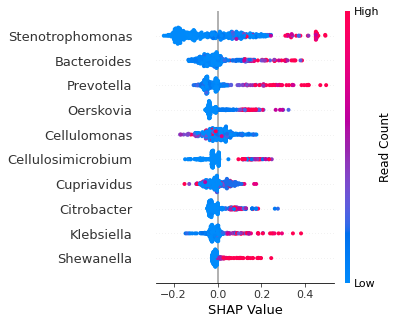

In [15]:
# Get SHAP summary before removing Cellulomonas and Agrobacterium
pre_model = XGBClassifier(**raw_params)
pre_model.fit(X=raw_CR, y=y)

pre_explainer = shap.TreeExplainer(pre_model, feature_pertubation='interventional', model_output='probability', data=raw_CR)
shap_pre = pre_explainer.shap_values(raw_CR)

shap.summary_plot(shap_pre, raw_CR, show=False, plot_size=(4, 5), color_bar_label='Read Count', max_display=25)
fig, ax = plt.gcf(), plt.gca()
ax.set_xlabel('SHAP Value')
plt.savefig(results / 'pre_shap.png', dpi=600, format='png', bbox_inches='tight')


### Number of Features

In [16]:
print('Neat', X.shape)
print('CR', raw_CR.shape)

Neat (438, 318)
CR (438, 10)


## Optimise and evaluate decontaminated models

In [17]:
raw_CR_results, raw_CR_params = optimise_evaluate(raw_CR, y)

RA_CR_results, RA_CR_params = optimise_evaluate(RA_CR, y)

metric_df = metric_df.append(pd.DataFrame({'Raw CR': raw_CR_results, 'RA CR': RA_CR_results}).round(3).T)
display(metric_df)

{'subsample': 0.9, 'scale_pos_weight': 0.9043478260869565, 'n_estimators': 270, 'max_depth': 3, 'gamma': 2.3555555555555556, 'colsample_bytree': 0.9526315789473684}
{'subsample': 0.7, 'scale_pos_weight': 0.9043478260869565, 'n_estimators': 270, 'max_depth': 4, 'gamma': 0.42222222222222217, 'colsample_bytree': 0.8105263157894737}


,test_precision,test_recall,test_F1,test_AUROC
Raw,0.959,0.883,0.918,0.969
RA,0.939,0.896,0.915,0.964
Raw CR,0.823,0.704,0.757,0.839
RA CR,0.799,0.743,0.768,0.849


### Fit clean models

In [18]:
raw_CR_model = XGBClassifier(**raw_CR_params)
raw_CR_model.fit(raw_CR, y)

RA_CR_model = XGBClassifier(**RA_CR_params)
RA_CR_model.fit(RA_CR, y)

XGBClassifier(colsample_bytree=0.8105263157894737, gamma=0.42222222222222217,
              max_depth=4, n_estimators=270,
              scale_pos_weight=0.9043478260869565, subsample=0.7)

## Interpreting model using SHAP values

### Plot of SHAP values per Feature

In [19]:
import matplotlib.pyplot as plt
explainer_CR = shap.TreeExplainer(raw_CR_model, feature_pertubation='interventional', model_output='probability', data=raw_CR)
shap_CR = explainer_CR.shap_values(raw_CR)

explainer_raw = shap.TreeExplainer(raw_model, feature_pertubation='interventional', model_output='probability', data=X)
shap_raw = explainer_raw.shap_values(X)

#### Dirty raw

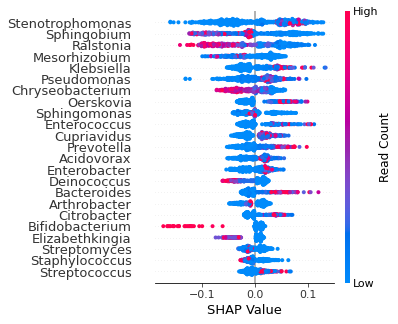

In [20]:
shap.summary_plot(shap_raw, X, show=False, plot_size=(4, 5), color_bar_label='Read Count', max_display=23)
fig, ax = plt.gcf(), plt.gca()
ax.set_xlabel('SHAP Value')
plt.savefig(results / 'raw_shap.png', dpi=600, format='png', bbox_inches='tight')

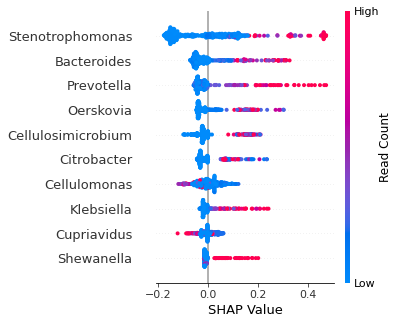

In [21]:
shap.summary_plot(shap_CR, raw_CR, show=False, plot_size=(4, 5), color_bar_label='Read Count', max_display=35)
fig, ax = plt.gcf(), plt.gca()
ax.set_xlabel('SHAP Value')
plt.savefig(results / 'raw_CR_shap.png', dpi=600, format='png', bbox_inches='tight')

### Force plot for healthy patient

Actual Classification 0
204


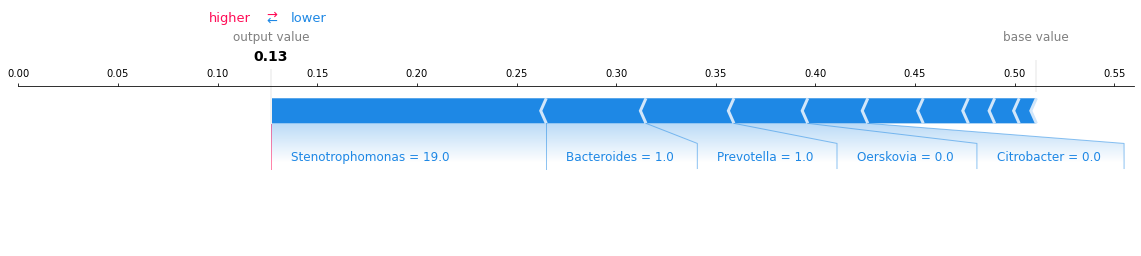

In [22]:
j = 201

print(f'Actual Classification {y[j]}')
print(raw_CR.index[j])

shap.force_plot(explainer_CR.expected_value, 
                shap_CR[j,:], 
                raw_CR.iloc[j,:],
                show=False,
                matplotlib=True)

plt.savefig(results / 'CR_force_plot.png', dpi=600, format='png', bbox_inches='tight')

In [23]:
import math
from scipy.stats import wilcoxon
import shap


def decontam_simple(X, y):
    to_retain = np.array([True] * X.shape[1])
    p_vals = []
    problems = []
    for i in range(X.shape[1]):
        try:
            genus = X.iloc[:, i].copy()
            pos = genus.loc[y == 1]
            neg = genus.loc[y == 0]
            
            if not (sum(pos != 0) >= 5 and sum(neg != 0) >= 5):
                raise ValueError
            
            # Downsample negative class
            if len(neg) > len(pos):
                neg = neg.sample(len(pos))
            elif len(neg) < len(pos):
                pos = pos.sample(len(neg))
            
            # Wilcoxon test
            _, p_val = wilcoxon(pos, neg, alternative='less')
            p_vals.append(p_val)
#             print(genus, p_val)

            if p_val < 0.05:
                to_retain[i] = False
        
        except ValueError:
            problems.append(X.columns[i])
            to_retain[i] = False
            

    return to_retain, p_vals, problems

In [24]:
simple_retain, simple_p, problems = decontam_simple(X_RA, y)
print(f'After simple decontamination: {sum(simple_retain)}') # No. of genera retained after simple decontamination

# Remove non-human associated pathogens
retain_names = list(set(X.columns[simple_retain]).intersection(set(meta)))
print(f'After removing non-human pathogens: {len(retain_names)}') # No. of genera retained after simple decontamination

simple_X = X.loc[:, retain_names]

# No. of genera with less than 5 septic and 5 healthy non-zero samples
print(f'No. of problems: {len(problems)}')
print(f'Final list of genera: {retain_names}')
pd.Series(retain_names).to_csv(datasets / 'simple_decontam_pathogens_external_validation.csv', index=False, header=False)

After simple decontamination: 191
After removing non-human pathogens: 78
No. of problems: 64
Final list of genera: ['Mycoplasma', 'Stenotrophomonas', 'Tsukamurella', 'Bacillus', 'Haematobacter', 'Actinomyces', 'Helicobacter', 'Dermabacter', 'Leptotrichia', 'Psychrobacter', 'Legionella', 'Sphingomonas', 'Cellulomonas', 'Aureimonas', 'Pseudoclavibacter', 'Aerococcus', 'Parabacteroides', 'Abiotrophia', 'Fusobacterium', 'Janibacter', 'Blautia', 'Cronobacter', 'Aeromonas', 'Propionibacterium', 'Collinsella', 'Azospirillum', 'Sutterella', 'Kocuria', 'Nocardiopsis', 'Rhodococcus', 'Alistipes', 'Streptococcus', 'Cupriavidus', 'Rothia', 'Chromobacterium', 'Yersinia', 'Pantoea', 'Vibrio', 'Nocardia', 'Bacteroides', 'Bifidobacterium', 'Arthrobacter', 'Moraxella', 'Pandoraea', 'Lactococcus', 'Actinomadura', 'Leifsonia', 'Proteus', 'Campylobacter', 'Brevibacterium', 'Aggregatibacter', 'Micrococcus', 'Microbacterium', 'Paenibacillus', 'Prevotella', 'Enterococcus', 'Ochrobactrum', 'Weissella', 'Erwin

In [25]:
simple_results, simple_params = optimise_evaluate(simple_X, y)
metric_df = metric_df.append(pd.DataFrame({'Raw simple': simple_results}).round(3).T)

{'subsample': 0.9, 'scale_pos_weight': 0.9043478260869565, 'n_estimators': 260, 'max_depth': 4, 'gamma': 1.0666666666666667, 'colsample_bytree': 0.38421052631578945}


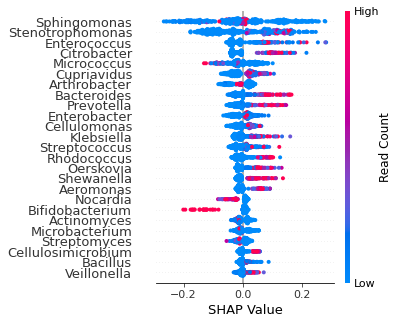

In [26]:
simple_model = XGBClassifier(**simple_params)
simple_model.fit(X=simple_X, y=y)

simple_explainer = shap.TreeExplainer(simple_model, feature_pertubation='interventional', 
                                      model_output='probability', 
                                      data=simple_X)

shap_simple = simple_explainer.shap_values(simple_X)

shap.summary_plot(shap_simple, simple_X, show=False, plot_size=(4, 5), color_bar_label='Read Count', max_display=25)
fig, ax = plt.gcf(), plt.gca()
ax.set_xlabel('SHAP Value')
plt.savefig(results / 'simple_decontam_shap.png', dpi=600, format='png', bbox_inches='tight')

In [27]:
# Intersecting genera between 
common = len(list(set(genera_new).intersection(set(retain_names))))
print(f'No. of genera in common: {common}\nNo. of genera in CR: {len(genera_new)}\nNo. of genera in simple decontam: {len(retain_names)}')

No. of genera in common: 10
No. of genera in CR: 10
No. of genera in simple decontam: 78


### Final Results

In [28]:
display(metric_df)

metric_df.to_csv(results / 'external_validation_model_results.csv', index=True, header=True)

,test_precision,test_recall,test_F1,test_AUROC
Raw,0.959,0.883,0.918,0.969
RA,0.939,0.896,0.915,0.964
Raw CR,0.823,0.704,0.757,0.839
RA CR,0.799,0.743,0.768,0.849
Raw simple,0.908,0.835,0.867,0.950
